Подключение модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

import load_month
import os
loader = load_month.TripsLoader()

Загрузка регионов 

In [2]:
regs = np.loadtxt('data/regs.txt', delimiter=',', dtype=np.int)
print(regs)

[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168]


Загруза данных для обучения

In [3]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/ytd_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
tpep_pickup_datetime                                                         
2015-06-01 00:00:00     40    32     7    17    60   129   153   271   294   
2015-06-01 01:00:00     17    20     5    13    38    90   111   163   246   
2015-06-01 02:00:00      5     5     0     8    25    47    97   139   207   
2015-06-01 03:00:00      5     6     0     6    27    26    68    77   208   
2015-06-01 04:00:00      8    16     2     6    21    39    53    81   109   

                      1131  ...   1630  1684  1733  1734  1783  2068  2069  \
tpep_pickup_datetime        ...                                              
2015-06-01 00:00:00     70  ...      8    17    10   639   437   230    15   
2015-06-01 01:00:00     28  ...      6     7    22   547   490   212    21   
2015-06-01 02:00:00     25  ...      6    11    10   234   215    95    69   
2015-06-01 03:00:00     29  ...     13     0     2    84    10    17     6   
2015-06-01 04:00:00      8  ...     20     1     0     9     4    14     5   

                      2118  2119  2168  
tpep_pickup_datetime                    
2015-06-01 00:00:00    271    90   123  
2015-06-01 01:00:00    237   124   119  
2015-06-01 02:00:00    253   105   112  
2015-06-01 03:00:00     78     3    94  
2015-06-01 04:00:00     62     1     1  

[5 rows x 102 columns]

In [ ]:
# подготовка данных за май и июнь
# запускать только один раз
df_may = loader.load_month(2016, 5)[regs]
df_june = loader.load_month(2016, 6)[regs]
df_may.to_csv('data/may16.csv', sep=';')
df_june.to_csv('data/june16.csv', sep=';')

Подготовка признаков для обучения

In [4]:
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()

In [5]:
k_list = [1, 5, 7, 11, 13, 19, 23]

# функция получения абсолютного времени
def get_t(dt_index):
    t = dt_index - datetime(2015, 6, 1, 0, 0, 0)
    t = t.days*24 + t.seconds // 3600
    return t


In [6]:
#  функция получения массива признаков X
def get_X(df):
    tt = get_t(df.index)
    t = tt.values * np.pi / 168 * 2
    l = []
    for k in k_list:
        l.append(np.sin(t * k))
        l.append(np.cos(t * k))


    # прирост в полпроцента и смягчение выбросов даст учет праздников
    # праздники 4 июля, рождество, день памяти повышенный спрос
    l.append([1 if (x.month == 7 and x.day == 4) \
              or (x.month == 12 and x.day in (24, 25, 26, 31)) \
              or (x.month == 1 and x.day == 1 and x.hour >= 8) \
              or (x.month == 5 and x.day >= 22 and x.date in tkd) \
              or (x.month == 9 and x.day <= 10 and x.date in tkd) \
              else 0 for x in df.index])
    # в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
    l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
              or (x.month == 11 and x.day == 1 and x.hour < 3)
              or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
              else 0 for x in df.index])
    # 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
    # плюс мы уберем сильный выброс
    l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23 and x.hour >=10) \
              or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
              else 0 for x in df.index])

    for d in range(7):
        l.append([1 if x.weekday() == d else 0 for x in df.index])
    
    
    for d in range(24):
        l.append([1 if x.hour == d else 0 for x in df.index])
       
    for d in range(12):
        l.append([1 if x.month == d else 0 for x in df.index])

    t = np.arange(df.shape[0]) * np.pi / 8760 * 2
    l.append(np.sin(t))
    l.append(np.cos(t))
    l.append(np.sin(t * 2))
    l.append(np.cos(t * 2))
    X = np.array(l).T
    return X

In [7]:

#  функция получения массива X с новыми признаками
def get_X_shifted(df, col):
    X = get_X(df)
    
    # количество поездок из рассматриваемого района в моменты времени y_T, y_{T-1}, y_{T-K}y
    # (параметр K можно подбирать; попробуйте начать, например, с 6)
    for i in range(1, 13):
        to_stack = df[col].shift(i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    # количество поездок из рассматриваемого района в моменты времени y_{T-24}, y_{T-48}, y_{T-24*K_d}
    # (параметр K_d можно подбирать; попробуйте начать, например, с 2)
    for i in range(1, 8):
        to_stack = df[col].shift(24*i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
        
    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю
    for window in [12, 24, 168]:
        r = df[col].shift(1).rolling(window=window, min_periods=window)
        to_stack = r.sum().values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    
    return X

Загрузка модулей модели

In [8]:
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

Выбор 10 рандомных моделей для первичного анализа

In [9]:
tests = np.random.choice(regs, 10)
print(tests)

[1380 1182 1131 1286 1285 1221 1336 1333 1388 1530]


Проверим отдельно градиентный бустинг, хорошо показвший себя на прошлых неделях
и линейную регрессию и градиентный бустинг на ее остатки

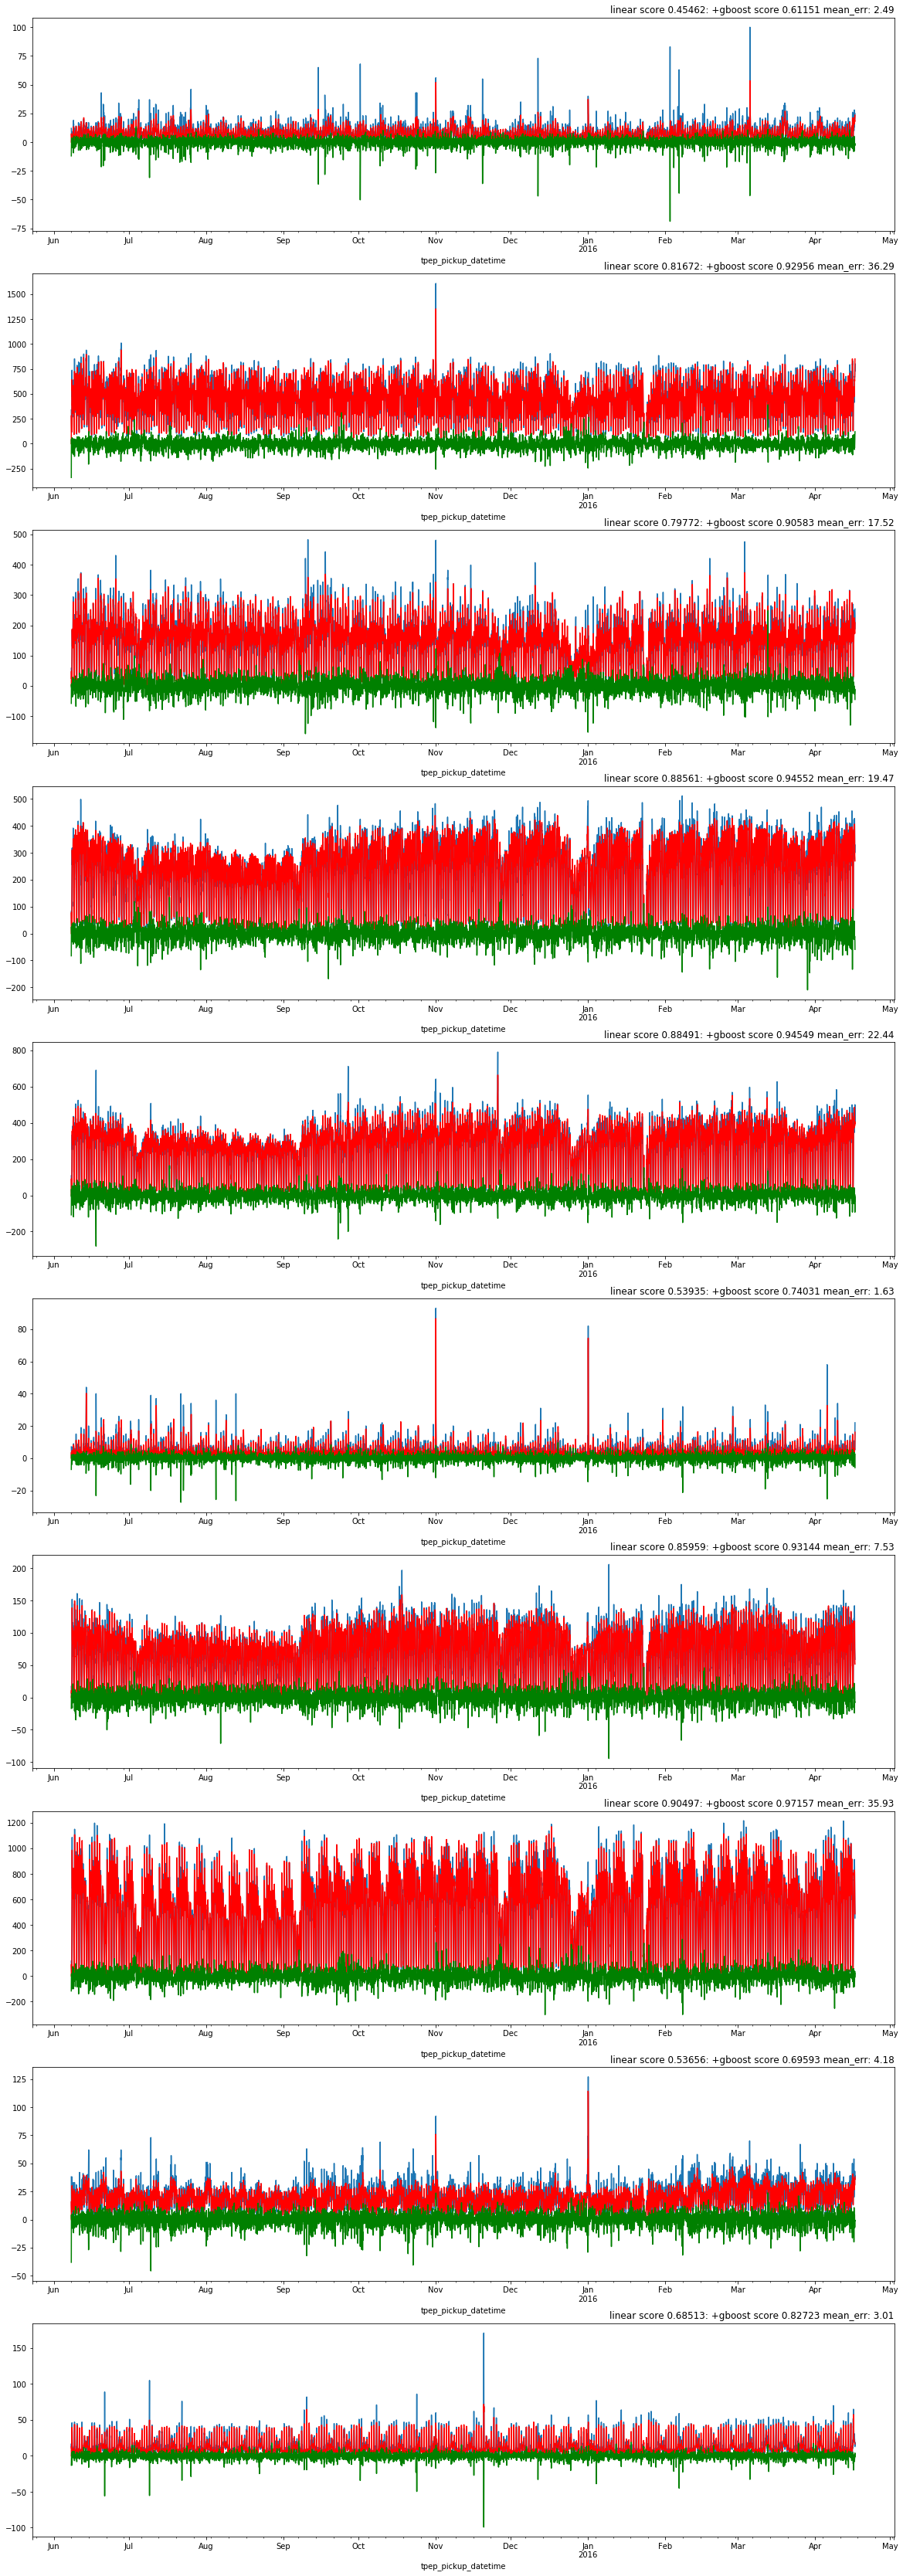

CPU times: user 41.9 s, sys: 302 ms, total: 42.2 s
Wall time: 42 s


In [10]:
%%time
model = LinearRegression()
gmodel = XGBRegressor(n_estimators=200)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
df['pred'] = 0
df['gpred'] = 0
l_g_score = []
for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
      
    X = X[start:end, :]
    Y = df[col].shift(-1)[start:end].values
    # линейная модель для выявления зависимостей общих зависимостей
    model.fit(X, Y)
    lpreds = model.predict(X)
    title = "linear score %.5f:"%r2_score(Y, lpreds)
    
    df['pred'] = 0
    
    # обучаем гбуст на отсатках
    
    Y_res = (Y - lpreds)
    gmodel.fit(X, Y_res)
    gpreds = gmodel.predict(X)
    
    # совмещаем прогнозы
    preds = lpreds + gpreds
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    
    score = r2_score(Y, preds)
    title += " +gboost score %.5f"%score
    mean_err = np.abs(Y - preds).mean()
    title += " mean_err: %.2f" % mean_err
    ax.set_title(title , loc='right')
    l_g_score.append(score)
    
    df['dif'] = (df['pred']-df[col])
    df[col][start:end].plot(ax=ax)
    df['pred'][start:end].plot(ax=ax, color='r')
    df['dif'][start:end].plot(ax=ax, color='g')
    

plt.show()

CPU times: user 39.2 s, sys: 159 ms, total: 39.4 s
Wall time: 39.4 s


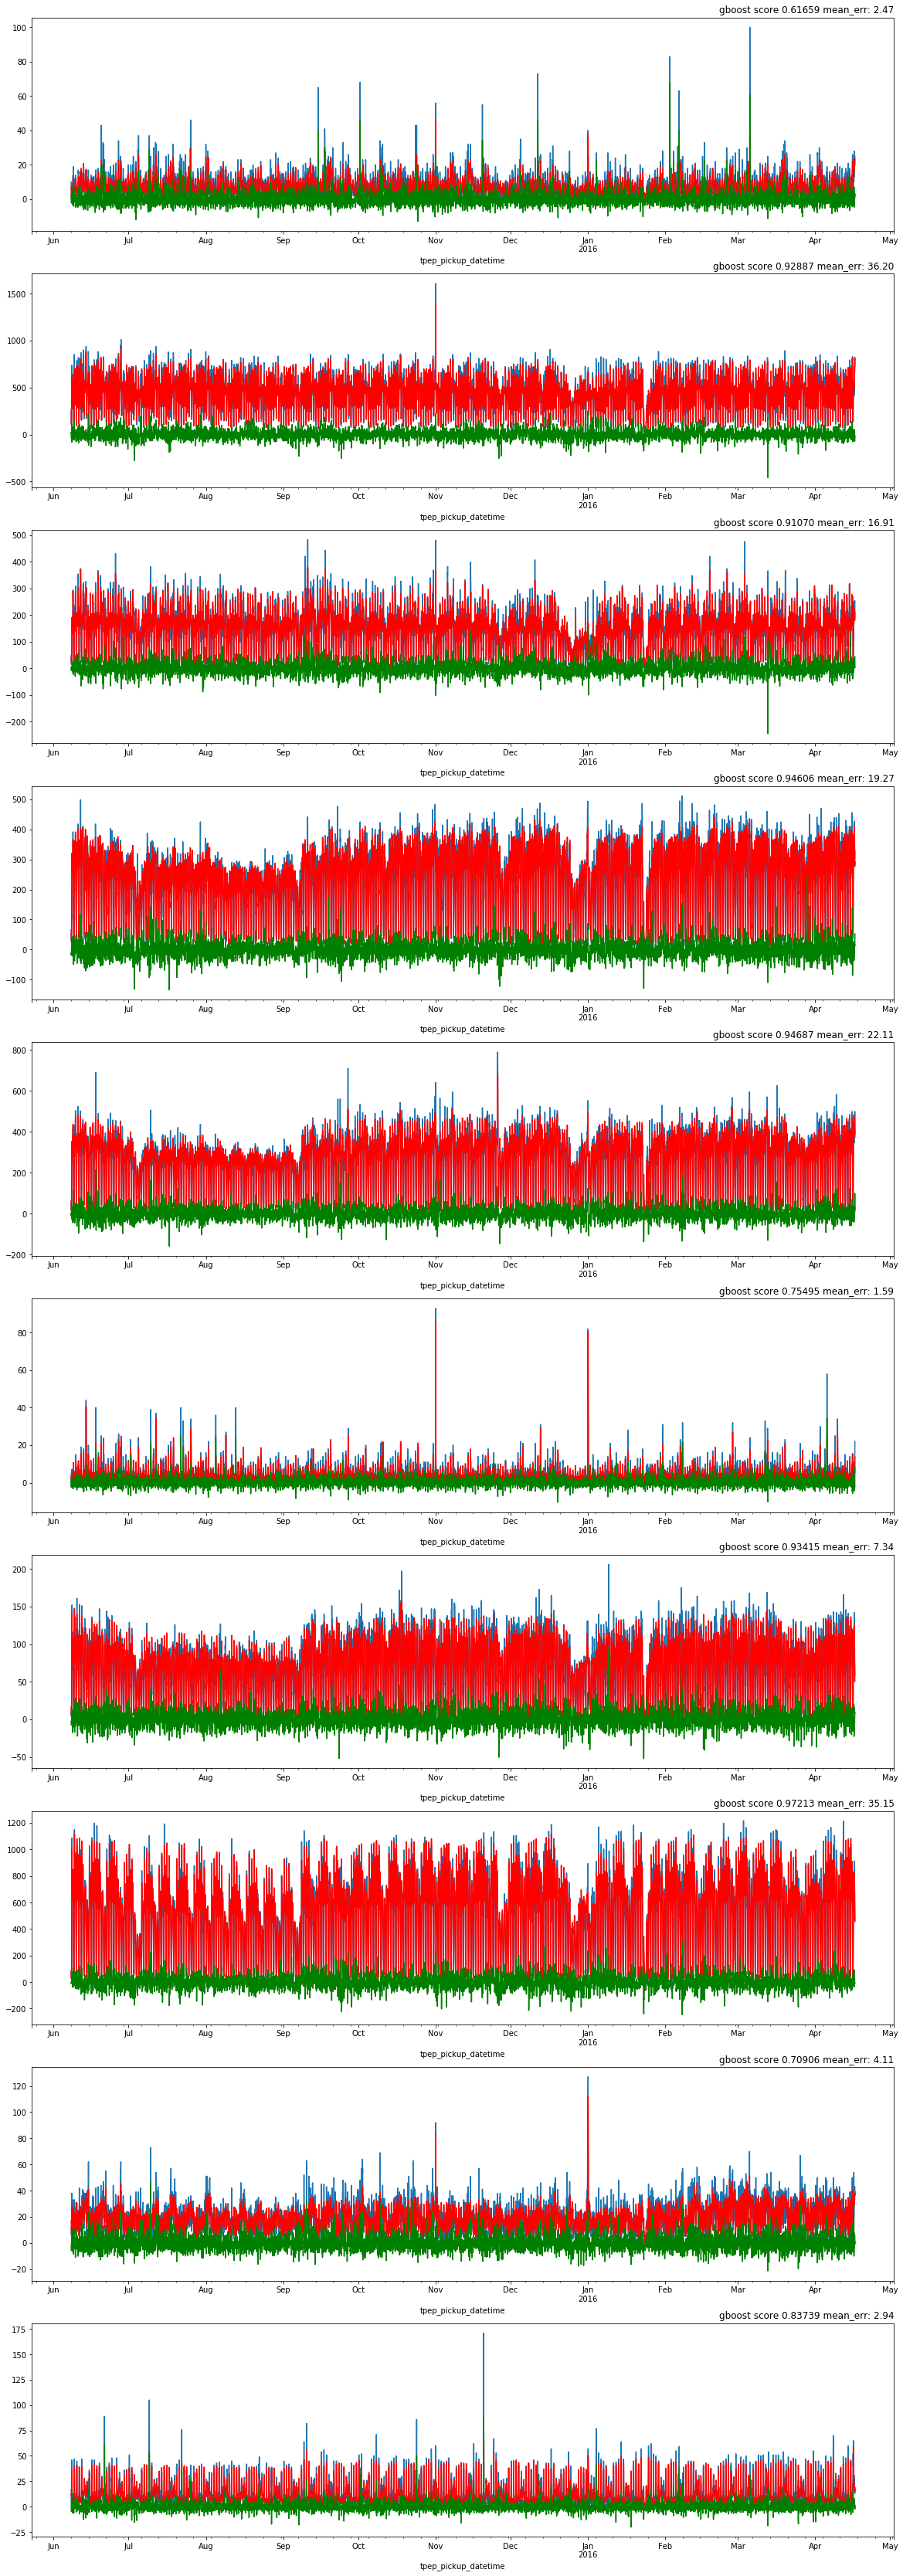

In [11]:
%%time
gmodel = XGBRegressor(n_estimators=200)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
g_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    score = r2_score(Y, preds)
    g_score.append(score)
    
    df['pred'] = 0
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    df['dif'] = (df[col] - df['pred'])
    
    # plots
    title = "gboost score %.5f"%score
    mean_err = np.abs(Y - preds).mean()
    title += " mean_err: %.2f" % mean_err
    
    df[col][start+1:end].plot(ax=ax)
    df['pred'][start+1:end].plot(ax=ax, color='r')
    df['dif'][start+1:end].plot(ax=ax, color='g')
    ax.set_title(title, loc='right')


Выведем полученные результаты

In [12]:
print("\t".join('%.3f'%x for x in l_g_score))
print("\t".join('%.3f'%x for x in g_score))

0.612	0.930	0.906	0.946	0.945	0.740	0.931	0.972	0.696	0.827
0.617	0.929	0.911	0.946	0.947	0.755	0.934	0.972	0.709	0.837


In [13]:
dif = np.array(l_g_score) - np.array(g_score)
print(dif)

[-0.0050791   0.00069422 -0.00486411 -0.00053804 -0.00137709 -0.0146341
 -0.00270802 -0.000558   -0.01312473 -0.01016014]


In [14]:
dif.mean()
# градиентный бустинг быстрее и ненмого точнее. соберем показатели по 6 моделям на +1, +2 ... +6 часов

-0.005234909551173117

Загрузим данные за май и июнь

In [15]:
# загрузка данных за май и июнь
df_may = pd.read_csv('data/may16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df_june = pd.read_csv('data/june16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df1 = pd.concat((df, df_may), sort=True)

Подберем параметры модели для дальнейшего использования на мае и июне
Подбирать модели буду на ячейке с самой большой абсолютной ошибкой

In [61]:
start = 169
end = -24

col = str(tests[1])
print(col)
X = get_X_shifted(df, col)[start:end, :]
Y = df[col].shift(-1)[start:end].values
print(X.shape, Y.shape)

1182
(7847, 74) (7847,)


In [63]:
%%time
# подбор лучших параметров 
from sklearn.model_selection import GridSearchCV
params = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 4, 5]
         }

grid = GridSearchCV(XGBRegressor(), params, cv=2, return_train_score=False, scoring='neg_median_absolute_error')
grid.fit(X, Y)
grid_df = pd.DataFrame.from_dict(grid.cv_results_)
grid_df.columns

CPU times: user 4min 5s, sys: 551 ms, total: 4min 5s
Wall time: 4min 6s


In [64]:
columns = ['mean_fit_time', 'std_fit_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators',
           'mean_test_score', 'std_test_score', 'rank_test_score']
grid_df[columns].sort_values(['rank_test_score']).head()

mean_fit_time  std_fit_time param_learning_rate param_max_depth  \
9        3.312960      0.012180                0.05               5   
10       5.210288      0.059470                0.05               5   
11       6.768466      0.006517                0.05               5   
20       1.676012      0.009651                 0.1               5   
21       3.290033      0.002738                 0.1               5   

   param_n_estimators  mean_test_score  std_test_score  rank_test_score  
9                 200       -32.897595        1.998772                1  
10                300       -33.005924        2.010162                2  
11                400       -33.128491        1.968945                3  
20                100       -33.260670        1.946144                4  
21                200       -33.498300        1.903435                5

Попробуем подобрать параметры поточнее

In [65]:
%%time
# подбор лучших параметров 
pre_params = grid.best_params_
lrs = pre_params["learning_rate"]
estims = pre_params["n_estimators"]
params = {
    "learning_rate": [lrs - 0.02, lrs, lrs + 0.02],
    "n_estimators": [estims - 50, estims, estims + 50],
    "max_depth": [pre_params["max_depth"]]
         }

grid = GridSearchCV(XGBRegressor(), params, cv=2, return_train_score=False, scoring='neg_median_absolute_error')
grid.fit(X, Y)
grid_df = pd.DataFrame.from_dict(grid.cv_results_)

CPU times: user 1min 8s, sys: 53.4 ms, total: 1min 8s
Wall time: 1min 8s


In [67]:
grid_df[columns].sort_values(['rank_test_score']).head()

mean_fit_time  std_fit_time param_learning_rate param_max_depth  \
5       4.127165      0.021491                0.05               5   
4       3.323282      0.008623                0.05               5   
6       2.479547      0.001764                0.07               5   
7       3.292461      0.008393                0.07               5   
8       4.098601      0.015528                0.07               5   

  param_n_estimators  mean_test_score  std_test_score  rank_test_score  
5                250       -32.717002        1.859055                1  
4                200       -32.897595        1.998772                2  
6                150       -33.223473        1.938694                3  
7                200       -33.265089        2.112328                4  
8                250       -33.343589        2.102646                5

In [68]:
%%time
# подбор лучших параметров 
pre_params = grid.best_params_
lrs = pre_params["learning_rate"]
estims = pre_params["n_estimators"]
params = {
    "learning_rate": [lrs - 0.01, lrs, lrs + 0.01],
    "n_estimators": [estims - 25, estims, estims + 25],
    "max_depth": [pre_params["max_depth"]]
         }

grid = GridSearchCV(XGBRegressor(), params, cv=2, return_train_score=False, scoring='neg_median_absolute_error')
grid.fit(X, Y)

CPU times: user 1min 23s, sys: 308 ms, total: 1min 23s
Wall time: 1min 24s


In [70]:
grid_df = pd.DataFrame.from_dict(grid.cv_results_)
grid_df[columns].sort_values(['rank_test_score']).head()

mean_fit_time  std_fit_time param_learning_rate param_max_depth  \
3       3.771181      0.010160                0.05               5   
4       4.213337      0.041188                0.05               5   
5       4.834440      0.059211                0.05               5   
1       4.141584      0.011752                0.04               5   
2       4.571289      0.033884                0.04               5   

  param_n_estimators  mean_test_score  std_test_score  rank_test_score  
3                225       -32.705649        2.047234                1  
4                250       -32.717002        1.859055                2  
5                275       -32.775084        1.988579                3  
1                250       -33.129157        2.100616                4  
2                275       -33.246912        1.960876                5

In [71]:
model_param = grid.best_params_
from sklearn.metrics import mean_absolute_error as mae

Проверим параметры на первоначальных данных

In [ ]:
%%time
gmodel = XGBRegressor(**model_param)
opt_g_score = np.zeros((6, 10))
mean_err = np.zeros((6, 10))
for t in range(1, 7):
    for ind, i in enumerate(tests):
        col = str(i)
        X = get_X_shifted(df, col)

        X = X[start:end, :]
        Y = df[col].shift(-t)[start:end].values

        gmodel.fit(X, Y)
        preds = gmodel.predict(X)
        score = r2_score(Y, preds)
        opt_g_score[t-1, ind]=score
        mean_err[t-1, ind] = mae(Y, preds)

In [76]:
print(mean_err.mean(axis=0))

[ 1.70927556 22.73932393 10.1728274  11.85079702 13.65798442  1.07038522
  4.57716537 21.08603668  2.83212304  2.00601236]


In [77]:
go_score = opt_g_score.mean(axis = 0)
print(go_score)
print(opt_g_score.std(axis=0))
print(opt_g_score.mean(axis = 1))

[0.71620774 0.9498193  0.93763473 0.96125915 0.95996027 0.80554748
 0.94895835 0.97812178 0.77514191 0.88494938]
[0.00673395 0.00233044 0.00150681 0.00125858 0.00242899 0.00791859
 0.00230148 0.00218928 0.00378962 0.00221786]
[0.89653727 0.89269379 0.89078496 0.89046276 0.88915636 0.89092491]


In [78]:
print("\t".join('%.3f'%x for x in g_score))
print("\t".join('%.3f'%x for x in go_score))
dif = np.array(go_score) - np.array(g_score)
print(dif.mean())

0.617	0.929	0.911	0.946	0.947	0.755	0.934	0.972	0.709	0.837
0.716	0.950	0.938	0.961	0.960	0.806	0.949	0.978	0.775	0.885
0.036084105857196444


подбор параметров дает прирост в качестве прогнозирования
модель дает весьма стабильные прогнозы в независимости от сдвига T+i
все работает намного быстрее, чем с АРИМА, так что отказ от добавления региона
как категориального признака утраиюващего размерность оправдан

In [79]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
X_may = get_X(pd.DataFrame(index=timerange))

In [80]:
print(X_may.shape)

(739, 52)


In [81]:
%%time
gmodel = XGBRegressor(**model_param)

y = []
time_len = X_may.shape[0]
reg_count = regs.shape[0]
Q = 0

for reg in regs:
    col = str(reg)
    for t in range(6):
        # fit model
        shift = (t+1) * -1
        X = get_X_shifted(df, col)
        X = X[start:end, :]
        Y = df[col].shift(shift)[start:end].values
        gmodel.fit(X, Y)

        # getting y_true
        Y = df_may[col].shift(-t).values
        preds = df[col][-169:].values

        for j in range(time_len):
            # getting input for preds
            x = X_may[j, :]
            x_d = np.array([preds[-i] for i in range(1, 13)])
            x_w = np.array([preds[-24*i] for i in range(1, 8)])
            x_r = np.array([preds[-13:-1].sum(), preds[-25:-1].sum(), preds[-169:-1].sum()])
            x = np.hstack((x, x_d, x_w, x_r))
            # getting prediction
            pred = gmodel.predict([x])[0]
            y_true = Y[j]
            #calculating Q
            Q += abs(y_true - pred)
            preds = np.append(preds, pred)
        
print(Q/(6*739*102))

34.46748236548226
CPU times: user 1h 14min 30s, sys: 5.33 s, total: 1h 14min 36s
Wall time: 1h 14min 40s


все прогнозы заняли около часа на том же железе, в сравнении с 2+ часами для SARIMAX.
Также, не требуется кластеризации, для каждого региона настраивалась своя модель.
точность выше чем на 4-й неделе 60.36610856860727.
 
подготовим код для результатов на каггл

In [82]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-05-31 23:00:00', end='2016-06-30 17:00:00')
X_june = get_X(pd.DataFrame(index=timerange))
print(X_june.shape)

(715, 52)


In [83]:
def get_date_str(time):
    return str(time.date()) + '_' + str(time.hour) + '_'

In [89]:
%%time

gmodel = XGBRegressor(**model_param)

y = []
time_len = X_june.shape[0]
reg_count = regs.shape[0]
Q = 0
header = 'id,y'

with open('data/output-june-gboost.csv', 'w', newline='\n') as f:
    f.write(header + '\n')
    
    for reg in regs:
        col = str(reg)
        reg_str = col + '_'
        
        preds_to_write = np.zeros((time_len, 6))
        
        for t in range(6):
            # fit model
            shift = (t+1) * -1
            X = get_X_shifted(df1, col)
            X = X[start:end, :]
            Y = df1[col].shift(shift)[start:end].values
            gmodel.fit(X, Y)

            # getting y_true
            Y = df_june[col].shift(-t).values
            preds = df1[col][-169:].values

            for j in range(time_len):
                # getting input for preds
                x = X_june[j, :]
                x_d = np.array([preds[-i] for i in range(1, 13)])
                x_w = np.array([preds[-24*i] for i in range(1, 8)])
                x_r = np.array([preds[-13:-1].sum(), preds[-25:-1].sum(), preds[-169:-1].sum()])
                x = np.hstack((x, x_d, x_w, x_r))
                # getting prediction
                pred = gmodel.predict([x])[0]
                preds_to_write[j, t] = pred
                y_true = Y[j]
                #calculating Q
                Q += abs(y_true - pred)
                preds = np.append(preds, pred)
                
        
        for ind, date in enumerate(timerange):
            date_str = get_date_str(date)
            for t, val in enumerate(preds_to_write[ind, :], 1):
                row = reg_str + date_str + str(t) + ',%.0f'%abs(round(val))
                f.write(row)
                f.write('\n')
        
        
print(Q / (6 * 102 * 715) )

34.38552557758017
CPU times: user 1h 21min 6s, sys: 5.21 s, total: 1h 21min 12s
Wall time: 1h 21min 13s


Качество прогноза улучшилось с Q=48 до 34

In [90]:
!head data/output-june-gboost.csv

id,y
1075_2016-05-31_23_1,21
1075_2016-05-31_23_2,6
1075_2016-05-31_23_3,4
1075_2016-05-31_23_4,5
1075_2016-05-31_23_5,8
1075_2016-05-31_23_6,0
1075_2016-06-01_0_1,4
1075_2016-06-01_0_2,2
1075_2016-06-01_0_3,6


Результаты с kaggle
89
new
Eugene K
34.36391